In [51]:
!pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 3.4 MB/s eta 0:00:00


In [150]:
# =================================
# LIBRARIES
# =================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from category_encoders import TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from scipy.stats import randint, uniform
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV


from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier, ExtraTreesClassifier, AdaBoostClassifier, HistGradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

import warnings
warnings.filterwarnings('ignore')

In [148]:
# =================================
# LOAD & PREVIEW DATA
# =================================

# Create a directory for the data
!mkdir -p data

# Download the dataset from data.transportation.gov
!wget -O data/raw_data.csv "https://data.transportation.gov/api/views/9ivb-8ae9/rows.csv?accessType=DOWNLOAD"
# Enable inline plotting for Jupyter Notebook
%matplotlib inline

# Set a style for the plots
sns.set(style="whitegrid")

# Load the Dataset
data_path = "data/raw_data.csv"
df_full = pd.read_csv(data_path)

# Display the first few rows of the dataframe
df_full.head()

#print(df.columns)


--2025-03-20 09:17:51--  https://data.transportation.gov/api/views/9ivb-8ae9/rows.csv?accessType=DOWNLOAD
Resolving data.transportation.gov (data.transportation.gov)... 52.206.68.26, 52.206.140.199, 52.206.140.205
Connecting to data.transportation.gov (data.transportation.gov)|52.206.68.26|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘data/raw_data.csv’

data/raw_data.csv       [             <=>    ]  91.30M  5.18MB/s    in 17s     

2025-03-20 09:18:10 (5.35 MB/s) - ‘data/raw_data.csv’ saved [95738829]



,NTD ID,Agency,Primary UZA UACE Code,Rail/Bus/Ferry,Mode Name,Mode,TOS,Fixed Route Flag,Year,Event Description,...,Occupant of Other Vehicle Injuries,Occupant of Other Vehicle Serious Injuries,Other Injuries,Other Serious Injuries,Suicide Injuries,Suicide Serious Injuries,Trespasser Inuries (Subtotal),Trespasser Serious Injuries (Subtotal),Total Serious Injuries,Person List
0,20080,New Jersey Transit Corporation,63217,Bus,Bus,MB,DO,True,2024,Bus was parked in <REDACTED> <REDACTED> and an...,...,0,0,0,0,0,0,0,0,0,NaN
1,40035,Central Florida Regional Transportation Authority,65863,Bus,Demand Response,DR,DO,False,2024,Another vehicle made other front contact with ...,...,1,0,0,0,0,0,0,0,0,I Operator Inside Adult (19 to 60) F ; I ...
2,50027,Metro Transit,57628,Rail,Light Rail,LR,DO,True,2024,Officers responded to a shooting . Suspect was...,...,0,0,0,0,0,0,0,0,0,F Passenger Adult (19 to 60) M
3,90026,San Diego Metropolitan Transit System,78661,Rail,Light Rail,LR,DO,True,2024,San Diego Police took a female into custody af...,...,0,0,0,0,0,0,0,0,0,I Wait Leave Adult (19 to 60) M Y
4,20080,New Jersey Transit Corporation,63217,Bus,Bus,MB,DO,True,2024,operator was driving down <REDACTED> <REDACTED...,...,1,0,0,0,0,0,0,0,0,I Occ Other Veh Adult (19 to 60) M


In [151]:

# =================================
# CLEANING & FEATURE ENGINEERING
# =================================
#df['Year'] = df['Event Date'].dt.year
#df['Month'] = df['Event Date'].dt.month
#df['Weekday'] = df['Event Date'].dt.weekday

# Selected Columns
# Define the list of columns to keep
columns_to_keep = [
    'NTD ID',
    'Primary UZA UACE Code',
    'Rail/Bus/Ferry',
    'Mode Name',
    'Mode',
    'TOS',
    'Fixed Route Flag',
    'Year',
    'Event Date',
    'Event Time',
    'Event Type',
    'Event Type Group',
    'Collision With',
    'Property Damage',
    'Total Injuries',
    'Total Fatalities',
    'Towed (Y/N)',
    'Number of Transit Vehicles Involved',
    'Number of Non-Transit Vehicles Involved',
    'Number of Cars on Involved Transit Vehicles',
    'Non-Transit Vehicle Type List',
    'Location Type',
    'Latitude',
    'Longitude',
    'Weather',
    'Lighting',
    'Road Configuration',
    'Path Condition',
    'Right of Way Condition',
    'Intersection Control Device',
    'Transit Vehicle Action',
    'Other Transit Vehicle Action Description',
    'Non-Transit Vehicle Action List',
    'Transit (Y/N)',
    'Fuel Type',
    'Vehicle Speed',
    'Transit Vehicle Type',
    'Non-Transit Vehicle Type',
    'Transit Vehicle Manufacturer',
    'Total Serious Injuries'
]

df = df_full[columns_to_keep]
df.columns = df.columns.str.replace(' ', '')
print(df.dtypes)

NTDID                                      int64
PrimaryUZAUACECode                         int64
Rail/Bus/Ferry                            object
ModeName                                  object
Mode                                      object
TOS                                       object
FixedRouteFlag                              bool
Year                                       int64
EventDate                                 object
EventTime                                 object
EventType                                 object
EventTypeGroup                            object
CollisionWith                             object
PropertyDamage                           float64
TotalInjuries                              int64
TotalFatalities                            int64
Towed(Y/N)                                object
NumberofTransitVehiclesInvolved            int64
NumberofNon-TransitVehiclesInvolved        int64
NumberofCarsonInvolvedTransitVehicles      int64
Non-TransitVehicleTy

In [152]:
eventtype = 'Non-Rail Collision'

df = df.query('EventType == @eventtype')

# Convert columns to datetime objects
df['EventDate'] = pd.to_datetime(df['EventDate'], format='%Y %B %d')
df['EventTime'] = pd.to_datetime(df['EventTime'].astype(str)).dt.time


# Extract features from Event Date
df['Month'] = df['EventDate'].dt.month
df['Day'] = df['EventDate'].dt.day
df['Weekday'] = df['EventDate'].dt.day_name()

# Create season feature (winter vs non-winter)
df['Season'] = df['Month'].apply(lambda m: 'winter' if m in [12, 1, 2] else 'non-winter')

# Convert Event Time to extract the hour (assuming it's in 24-hour format)
# Since 'Event Time' is already datetime.time, you can extract hour directly:
df['Hour'] = df['EventTime'].apply(lambda t: t.hour) #Using apply to access the hour attribute

# Categorize time of day
def categorize_time(hour):
    if 5 <= hour < 12:
        return 'morning'
    elif 12 <= hour < 17:
        return 'afternoon'
    elif 17 <= hour < 21:
        return 'evening'
    else:
        return 'night'

df['TimeOfDay'] = df['Hour'].apply(categorize_time)

# Create rush hour flag
def is_rush_hour(hour):
    return 1 if (7 <= hour < 10 or 16 <= hour < 19) else 0

df['RushHour'] = df['Hour'].apply(is_rush_hour) #Removed extra =

# Select columns to display for checking
columns = ['EventDate', 'EventTime', 'Hour', 'TimeOfDay', 'RushHour', 'Season', 'Weekday', 'Day', 'Month']
print(df[columns].head())

# Store the new dataset to a new CSV file
#df = pd.read_csv('../data/feature_engineered_data.csv', index=False)

df['Towed(Y/N)'] = df['Towed(Y/N)'].map({'Y': True, 'N': False})

df['FixedRouteFlag'] = df['FixedRouteFlag'].map({'true': True, 'false': False})

print(df.dtypes)
df.columns = df.columns.str.replace(' ', '')


    EventDate EventTime  Hour  TimeOfDay  RushHour      Season    Weekday  \
0  2024-11-30  08:46:00     8    morning         1  non-winter   Saturday   
1  2024-11-30  19:09:00    19    evening         0  non-winter   Saturday   
4  2024-11-27  15:20:00    15  afternoon         0  non-winter  Wednesday   
8  2024-11-25  07:38:00     7    morning         1  non-winter     Monday   
11 2024-11-23  18:08:00    18    evening         1  non-winter   Saturday   

    Day  Month  
0    30     11  
1    30     11  
4    27     11  
8    25     11  
11   23     11  
NTDID                                             int64
PrimaryUZAUACECode                                int64
Rail/Bus/Ferry                                   object
ModeName                                         object
Mode                                             object
TOS                                              object
FixedRouteFlag                                   object
Year                                       

In [153]:
# count the number of missing values in each column
print(df.dtypes)
missing_values = df.isnull().sum()

# drop columns with more than 10% missing values
columns_to_drop = missing_values[missing_values > 0.1 * df.shape[0]].index
print(columns_to_drop)
df = df.drop(columns=columns_to_drop)

# drop rows with missing values
df = df.dropna()  #drop missing values first before dropping columns?


# drop duplicates
df = df.drop_duplicates()

# save the cleaned data, save to data folder as data_cleaned.csv
df.to_csv('data/cleaned_data.csv', index=False)

# print the number of rows and columns in the cleaned data
print(df.shape)

# print the number of missing values in the cleaned data
print(df.isnull().sum())

# print the number of duplicates in the cleaned data
print(df.duplicated().sum())

nominal_cols = ['Rail/Bus/Ferry', 'ModeName', 'Mode', 'TOS', 'Weather', 'Lighting', 'RoadConfiguration', 'PathCondition', 'RightofWayCondition', 'FuelType', 'TransitVehicleType', 'TransitVehicleManufacturer', 'NTDID', 'PrimaryUZAUACECode', 'Year', 'Month', 'Day']  # Update with actual nominal variables
df[nominal_cols] = df[nominal_cols].astype('category')

print(df.dtypes)

# print the first few rows of the cleaned data
print(df.head())

NTDID                                             int64
PrimaryUZAUACECode                                int64
Rail/Bus/Ferry                                   object
ModeName                                         object
Mode                                             object
TOS                                              object
FixedRouteFlag                                   object
Year                                              int64
EventDate                                datetime64[ns]
EventTime                                        object
EventType                                        object
EventTypeGroup                                   object
CollisionWith                                    object
PropertyDamage                                  float64
TotalInjuries                                     int64
TotalFatalities                                   int64
Towed(Y/N)                                         bool
NumberofTransitVehiclesInvolved                 

In [154]:
# =================================
# DEFINE TARGET VARIABLE
# =================================
df['MajorSafety'] = (
    (df['TotalFatalities'] > 0) |
    (df['TotalSeriousInjuries'] >0) |
    (df['TotalInjuries'] >0) |
    (df['PropertyDamage'] >25000)

).astype(int)

X = df.drop(columns=['MajorSafety', 'TotalFatalities','TotalSeriousInjuries','TotalInjuries', 'PropertyDamage', 'Hour', 'EventDate', 'EventTime'])
y = df['MajorSafety']

#f['Is_Severe'].value_counts()


In [155]:
# =================================
# PREPROCESSING PIPELINE
# =================================
cat_cols = X.select_dtypes(include='object').columns
num_cols = X.select_dtypes(include=['int64', 'float64','bool']).columns

#preprocessor = ColumnTransformer([
#    ('num', StandardScaler(), num_cols),
#    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
#])


preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', TargetEncoder(handle_unknown='ignore'), cat_cols)  # Replace OHE with TargetEncoder
])

In [161]:
baseline_classifier = RandomForestClassifier(n_estimators=200, max_depth = 15, random_state=42)
classifier1= GradientBoostingClassifier()
classifier2= BaggingClassifier(DecisionTreeClassifier())
classifier3= ExtraTreesClassifier(n_estimators=100, random_state=42)
classifier10 = KNeighborsClassifier(n_neighbors=5)


In [162]:
Pipeline_Base = Pipeline([
    ('preprocessing', preprocessor),
    ('classifier', baseline_classifier)
])


Pipeline_1 = Pipeline([
    ('preprocessing', preprocessor),
    ('classifier', classifier1)
])

Pipeline_2 = Pipeline([
    ('preprocessing', preprocessor),
    ('classifier', classifier2)
])

Pipeline_3 = Pipeline([
    ('preprocessing', preprocessor),
    ('classifier', classifier3)
])

#BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier
#KNeighborsClassifier()


In [163]:
# =================================
# MODEL TRAINING
# =================================
#pipeline = Pipeline([
#    ('preprocessing', preprocessor),
#    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
#])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [160]:
param_grid = {
    'classifier__n_estimators': [50, 100, 150, 200],
    'classifier__max_depth': [5, 10, 15, 20]
}

# Perform GridSearchCV
grid_search = GridSearchCV(Pipeline_Base, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Output the best parameters and score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")


Best parameters: {'classifier__max_depth': 15, 'classifier__n_estimators': 200}
Best score: 0.7921443300178334


In [164]:
Pipeline_Base.fit(X_train, y_train)
y_pred = Pipeline_Base.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.29      0.39      2834
           1       0.82      0.94      0.88      9597

    accuracy                           0.79     12431
   macro avg       0.71      0.62      0.63     12431
weighted avg       0.77      0.79      0.77     12431

Confusion Matrix:
[[ 811 2023]
 [ 532 9065]]
ROC-AUC Score: 0.6153669853457058



Top 10 Predictive Features:
                                       Feature  Importance
0                              num__Towed(Y/N)    0.579396
4                            num__VehicleSpeed    0.067742
11   cat__OtherTransitVehicleActionDescription    0.056840
13                                cat__Weekday    0.050051
10                   cat__TransitVehicleAction    0.037263
8                           cat__CollisionWith    0.036128
9                            cat__LocationType    0.031828
15                              cat__TimeOfDay    0.029913
12                           cat__Transit(Y/N)    0.029654
3   num__NumberofCarsonInvolvedTransitVehicles    0.027279


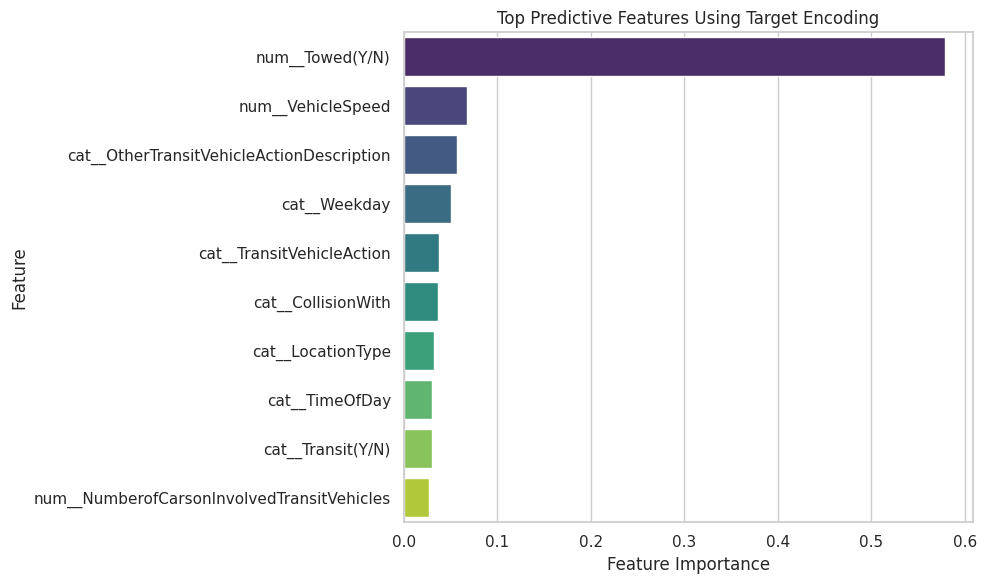

In [165]:
# Access trained classifier
rf_model = Pipeline_Base.named_steps['classifier']

# Get feature names
all_feature_names = Pipeline_Base.named_steps['preprocessing'].get_feature_names_out()

# Get feature importances
importances = rf_model.feature_importances_

# Create DataFrame for visualization
feat_importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

top_n = 10
print(f"\nTop {top_n} Predictive Features:")
print(feat_importance_df.head(top_n))

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_importance_df.head(top_n), palette='viridis')
plt.title("Top Predictive Features Using Target Encoding")
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


Top 10 Predictive Features:
                                      Feature  Importance  \
3                             num__Towed(Y/N)    0.204898   
13                             cat__EventTime    0.131560   
0                                  num__NTDID    0.080748   
1                     num__PrimaryUZAUACECode    0.062395   
2                                   num__Year    0.058439   
7                           num__VehicleSpeed    0.047413   
29                               cat__Weekday    0.044104   
28            cat__TransitVehicleManufacturer    0.040159   
24  cat__OtherTransitVehicleActionDescription    0.034126   
31                             cat__TimeOfDay    0.026399   

                             Original Feature  
3                             num__Towed(Y/N)  
13                             cat__EventTime  
0                                  num__NTDID  
1                     num__PrimaryUZAUACECode  
2                                   num__Year  
7          

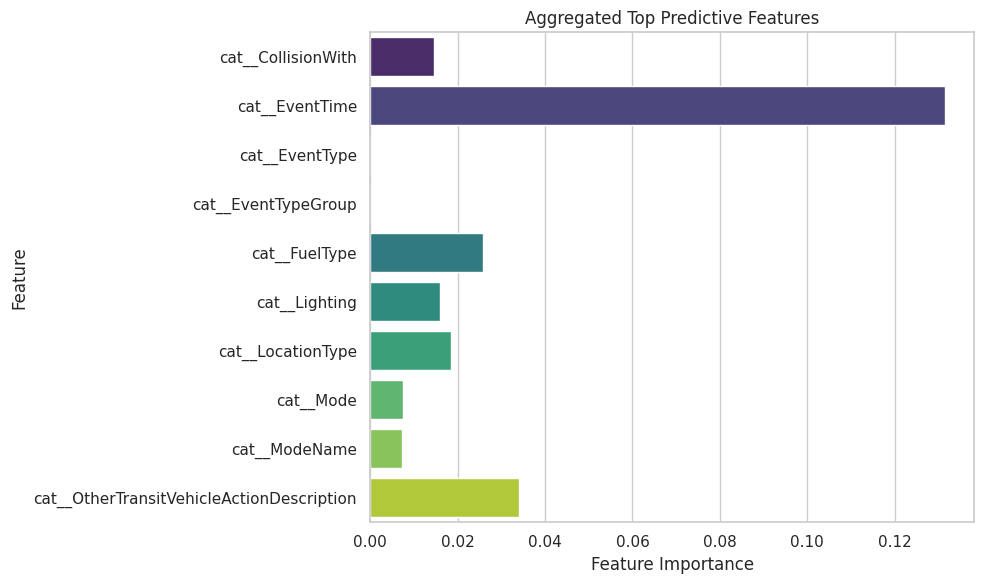

In [58]:
# =================================
# FEATURE IMPORTANCE
# =================================
# Access trained model
rf_model = Pipeline_Base.named_steps['classifier']

# Get feature names
ohe = Pipeline_Base.named_steps['preprocessing'].named_transformers_['cat']
encoded_cat_cols = ohe.get_feature_names_out(cat_cols)
#all_feature_names = list(num_cols) + list(encoded_cat_cols)
all_feature_names = Pipeline_Base.named_steps['preprocessing'].get_feature_names_out()

# Get importances
importances = rf_model.feature_importances_
feat_importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)


# Mapping only for categorical features
#original_feature_map = {encoded: original.split('_')[0] for encoded, original in zip(encoded_cat_cols, cat_cols)}
original_feature_map = {encoded: encoded.split('_')[0] for encoded in encoded_cat_cols}

# Aggregate importance by original feature
#feat_importance_df['Original Feature'] = feat_importance_df['Feature'].apply(
#    lambda x: original_feature_map[x] if x in original_feature_map else x
#)

feat_importance_df['Original Feature'] = feat_importance_df['Feature'].apply(
    lambda x: original_feature_map[x] if x in encoded_cat_cols else x
)

top_n = 10
print(f"\nTop {top_n} Predictive Features:")
print(feat_importance_df.head(top_n))

aggregated_importance = feat_importance_df.groupby('Original Feature')['Importance'].sum().reset_index()
# Plot the aggregated feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Original Feature', data=aggregated_importance.head(top_n), palette='viridis')
plt.title("Aggregated Top Predictive Features")
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


# Display top N features

#print(f"\nTop {top_n} Predictive Features:")
#print(feat_importance_df.head(top_n))

# Plot top features
#plt.figure(figsize=(10, 6))
#sns.barplot(x='Importance', y='Feature', data=feat_importance_df.head(top_n), palette='viridis')
#plt.title("Top Predictors of Major Safety Incidents")
#plt.xlabel("Feature Importance")
#plt.ylabel("Feature")
#plt.tight_layout()
#plt.show()


In [131]:
Pipeline_1.fit(X_train, y_train)
y_pred = Pipeline_1.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred))

ValueError: Input X contains NaN.
GradientBoostingClassifier does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [128]:
# =================================
# FEATURE IMPORTANCE
# =================================
# Access trained model
rf_model = Pipeline_1.named_steps['classifier']

# Get feature names
all_feature_names = Pipeline_1.named_steps['preprocessing'].get_feature_names_out()

# Get feature importances
importances = rf_model.feature_importances_

# Create DataFrame for visualization
feat_importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

top_n = 10
print(f"\nTop {top_n} Predictive Features:")
print(feat_importance_df.head(top_n))

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_importance_df.head(top_n), palette='viridis')
plt.title("Top Predictive Features Using Target Encoding")
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

AttributeError: 'HistGradientBoostingClassifier' object has no attribute 'feature_importances_'

In [121]:
Pipeline_2.fit(X_train, y_train)
y_pred = Pipeline_2.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.33      0.23      0.27      2834
           1       0.79      0.86      0.82      9597

    accuracy                           0.72     12431
   macro avg       0.56      0.54      0.55     12431
weighted avg       0.68      0.72      0.70     12431

Confusion Matrix:
[[ 642 2192]
 [1324 8273]]
ROC-AUC Score: 0.5442875769296582



Top 10 Predictive Features:
                                      Feature  Importance  \
13                               cat__Weekday    0.191767   
4                           num__VehicleSpeed    0.181880   
15                             cat__TimeOfDay    0.117500   
11  cat__OtherTransitVehicleActionDescription    0.077301   
9                           cat__LocationType    0.071716   
5                               num__RushHour    0.065112   
14                                cat__Season    0.056687   
12                          cat__Transit(Y/N)    0.056543   
10                  cat__TransitVehicleAction    0.054678   
8                          cat__CollisionWith    0.045576   

                             Original Feature  
13                               cat__Weekday  
4                           num__VehicleSpeed  
15                             cat__TimeOfDay  
11  cat__OtherTransitVehicleActionDescription  
9                           cat__LocationType  
5          

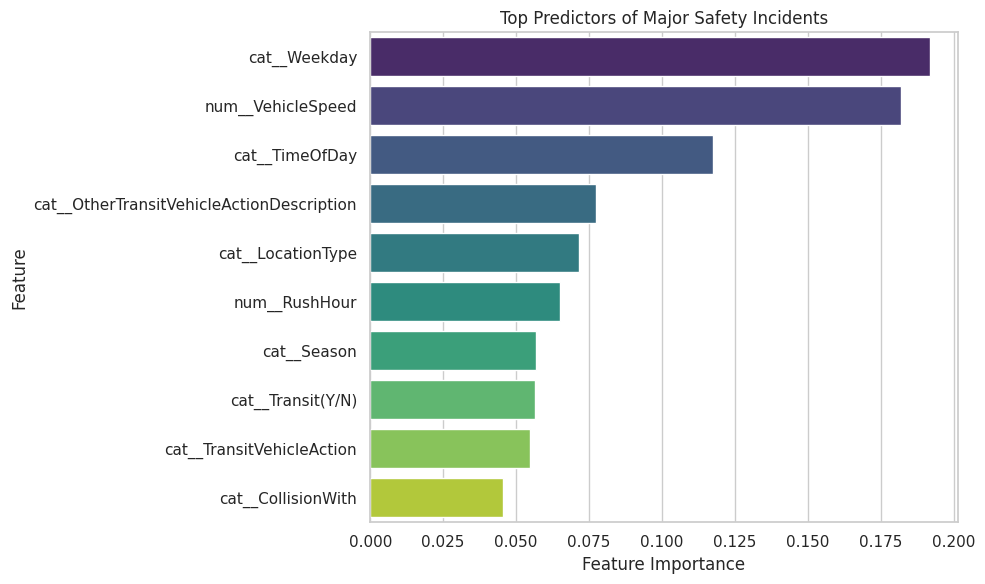

In [125]:
# =================================
# FEATURE IMPORTANCE
# =================================
# Access trained model


rf_model = Pipeline_2.named_steps['classifier']

# Get feature names
ohe = Pipeline_2.named_steps['preprocessing'].named_transformers_['cat']
encoded_cat_cols = ohe.get_feature_names_out(cat_cols)
#all_feature_names = list(num_cols) + list(encoded_cat_cols)
all_feature_names = Pipeline_2.named_steps['preprocessing'].get_feature_names_out()


# Get importances
importances = np.mean([
            tree.feature_importances_ for tree in rf_model.estimators_
        ], axis=0)


feat_importance_df = pd.DataFrame({
        'Feature': all_feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)

# Get importances
#importances = rf_model.feature_importances_
#feat_importance_df = pd.DataFrame({
#    'Feature': all_feature_names,
#    'Importance': importances
#}).sort_values(by='Importance', ascending=False)


# Mapping only for categorical features
#original_feature_map = {encoded: original.split('_')[0] for encoded, original in zip(encoded_cat_cols, cat_cols)}
original_feature_map = {encoded: encoded.split('_')[0] for encoded in encoded_cat_cols}

# Aggregate importance by original feature
#feat_importance_df['Original Feature'] = feat_importance_df['Feature'].apply(
#    lambda x: original_feature_map[x] if x in original_feature_map else x
#)

feat_importance_df['Original Feature'] = feat_importance_df['Feature'].apply(
    lambda x: original_feature_map[x] if x in encoded_cat_cols else x
)


top_n = 10
print(f"\nTop {top_n} Predictive Features:")
print(feat_importance_df.head(top_n))

# Plot top features
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_importance_df.head(top_n), palette='viridis')
plt.title("Top Predictors of Major Safety Incidents")
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [123]:
Pipeline_3.fit(X_train, y_train)

# Predict on Test Set
y_pred = Pipeline_3.predict(X_test)
y_probs = Pipeline_3.predict_proba(X_test)[:, 1]  # Probabilities for class 1


print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_probs))

Classification Report:
              precision    recall  f1-score   support

           0       0.32      0.21      0.25      2834
           1       0.79      0.87      0.83      9597

    accuracy                           0.72     12431
   macro avg       0.55      0.54      0.54     12431
weighted avg       0.68      0.72      0.70     12431

Confusion Matrix:
[[ 600 2234]
 [1283 8314]]
ROC-AUC Score: 0.6211919575549552



Top 10 Predictive Features:
                                  Feature  Importance
4                            VehicleSpeed    0.300855
13                                Weekday    0.195804
11   OtherTransitVehicleActionDescription    0.116369
9                            LocationType    0.080410
10                   TransitVehicleAction    0.069832
15                              TimeOfDay    0.057510
12                           Transit(Y/N)    0.047155
3   NumberofCarsonInvolvedTransitVehicles    0.033250
8                           CollisionWith    0.030975
5                                RushHour    0.024003


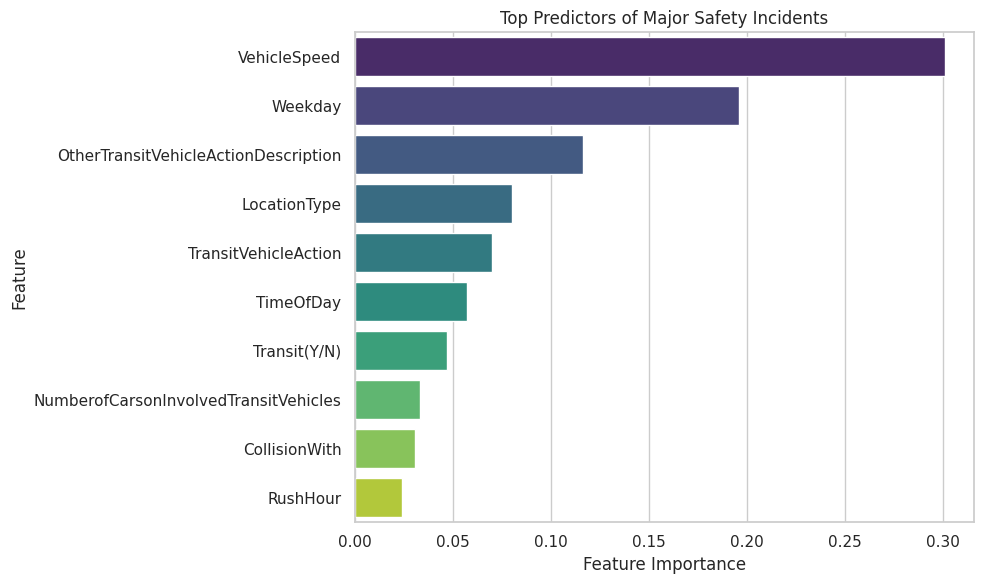

In [124]:
# =================================
# FEATURE IMPORTANCE
# =================================
# Access trained model
rf_model = Pipeline_3.named_steps['classifier']

# Get feature names
ohe = Pipeline_3.named_steps['preprocessing'].named_transformers_['cat']
encoded_cat_cols = ohe.get_feature_names_out(cat_cols)
all_feature_names = list(num_cols) + list(encoded_cat_cols)

# Get importances
importances = rf_model.feature_importances_
feat_importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Display top N features
top_n = 10
print(f"\nTop {top_n} Predictive Features:")
print(feat_importance_df.head(top_n))

# Plot top features
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_importance_df.head(top_n), palette='viridis')
plt.title("Top Predictors of Major Safety Incidents")
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [ ]:
Pipeline_10.fit(X_train, y_train)
# Compute Permutation Importance
KNNresult = permutation_importance(Pipeline_10, X_test, y_test, n_repeats=1, random_state=42, scoring='accuracy')

In [ ]:
y_pred = Pipeline_10.predict(X_test)  # Binary class labels
y_probs = Pipeline_10.predict_proba(X_test)[:, 1]  # Probabilities

# Print Evaluation Metrics
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("ROC-AUC Score:", roc_auc_score(y_test, y_probs))  # Use probabilities instead of labels

In [ ]:

ohe = Pipeline_10.named_steps['preprocessing'].named_transformers_['cat']
encoded_cat_cols = ohe.get_feature_names_out(cat_cols)
all_feature_names = list(num_cols) + list(encoded_cat_cols)

feat_importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': KNNresult.importances_mean
}).sort_values(by='Importance', ascending=False)


# Display top N features
top_n = 10
print(f"\nTop {top_n} Predictive Features:")
print(feat_importance_df.head(top_n))

# Plot top features
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_importance_df.head(top_n), palette='viridis')
plt.title("Top Predictors of Major Safety Incidents")
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()